<a href="https://colab.research.google.com/github/abhijain864/Summer_Project_2020/blob/main/Summer_project_2020_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # Importing libraries
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Running the pre-trained model VGG16

In [ ]:
# Importing libraries
import os
import re

#Extracting images from the zipped file
import requests, zipfile, io
r = requests.get('https://github.com/jcpeterson/percept2vec/blob/master/animals.zip?raw=true') 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
# Generate integer labels from model output
def get_int_label(probs):
  labels = np.argmax(probs, axis = 1)
  return labels

# Generate one_hot_labels from labels
def get_one_hot_label(labels):
  one_hot_label = tf.keras.utils.to_categorical(labels, num_classes=1000)
  return one_hot_label
  
# Get imagenet labels from model output
def get_imagenet_label(probs):
  labels = []
  for img_prob in decode_pred(probs, top=1):
    labels.append(img_prob[0])
  return labels

# Loading the pre-trained VGG16 model
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

preprocess = tf.keras.applications.mobilenet_v2.preprocess_input
decode_pred = tf.keras.applications.mobilenet_v2.decode_predictions

14540800/14536120 [==============================] - 0s 0us/step


Loading image data

In [ ]:
img_data = np.zeros((1, 224, 224, 3))
filenames = os.listdir('images')
filenames.remove('desktop.ini')

# Sorting the filenames
img_no = [re.findall(r'\d+', filename)[0] for filename in filenames]
img_no.sort()
sorted_filenames = ['stim-' + no +'.png' for no in img_no]

for filename in sorted_filenames:
  path = 'images/' + filename
  img = load_img(path, target_size=(224, 224))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess(img)
  img_data = np.append(img_data, img, axis = 0)
  
img_data = np.delete(img_data, 0, 0)
print(img_data.shape)

(120, 224, 224, 3)


Running the pre-trained VGG16 model

In [ ]:
img_probs = pretrained_model.predict(img_data)
true_labels = get_int_label(img_probs)
one_hot_labels = get_one_hot_label(true_labels)
imagenet_labels = get_imagenet_label(img_probs)

40960/35363 [==================================] - 0s 0us/step


<function matplotlib.pyplot.show>

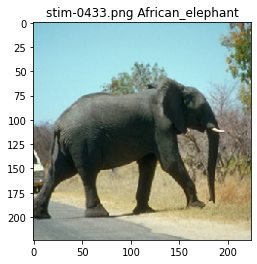

In [ ]:
#Visualizing a random image...
i = np.random.choice(120, 1)[0]
show_image = i
x = img_data[i]
x = array_to_img(x)
plt.figure()
plt.imshow(x)
plt.title(sorted_filenames[i] + " " + imagenet_labels[i][1])
plt.show

## Generating Adversarial examples (FGSM)

We assume that the model is predicting correctly.

In [ ]:
# Convert as needed for calculating gradient
def convert(labels, img = None, ind = None, data = None):
  if ind is None:
    image = img
    label = get_one_hot_label(labels)
  else:
    image = data[ind]
    label = get_one_hot_label(labels)[i]
  
  image = np.expand_dims(image, axis=0)
  image = tf.convert_to_tensor(image)
  label = np.expand_dims(label, axis = 0)
  label = tf.convert_to_tensor(label)

  return (image, label)

# Generate signed_gradient
def perturbation_generator(input_image, input_label, loss_object):
  if loss_object is None:
    loss_object = tf.keras.losses.CategoricalCrossentropy()
  else:
    loss_object = tf.keras.losses.get(loss_object)

  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  gradient = tape.gradient(loss, input_image)   # Get the gradients of the loss w.r.t to the input image.
  signed_grad = tf.sign(gradient)   # Get the sign of the gradients to create the perturbation

  return signed_grad

# Generate adversarial image data for all images
def adversarial_imageset_generator(eps, data = img_data, labels = one_hot_labels, loss = None):
  perturbed_imgs = np.zeros_like(img_data)

  for i in range(len(perturbed_imgs)):
    image = np.expand_dims(data[i], axis=0)
    image = tf.convert_to_tensor(image)
    label = np.expand_dims(labels[i], axis = 0)
    label = tf.convert_to_tensor(label)
    
    perturbation = perturbation_generator(image, label, loss)
    adv_img = image + eps*perturbation
    perturbed_imgs[i] = adv_img[0]

  return perturbed_imgs

def Accuracy(data, labels, model):
  pred = model.predict(data)
  pred_labels = get_int_label(pred)

  compare = np.equal(pred_labels, labels)
  correct = np.count_nonzero(compare)
  accuracy = correct/len(pred)  
  
  return accuracy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


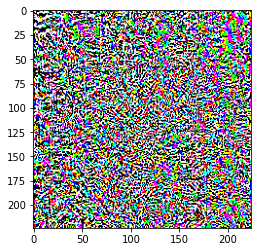

In [ ]:
# Visualizing perturbations for a random image
i = np.random.choice(120, 1)[0]

image = np.expand_dims(img_data[i], axis=0)
image = tf.convert_to_tensor(image)
label = np.expand_dims(one_hot_labels[i], axis = 0)
label = tf.convert_to_tensor(label)

perturbation = perturbation_generator(image, label, loss_object = 'categorical_crossentropy')
print(perturbation.shape)
plt.imshow(perturbation[0])

Generating perturbed images and checking accuracy

In [ ]:
epsilon = 0.1       # Chosen empirically to get an error rate of more than 99%
perturbed_imgs = adversarial_imageset_generator(epsilon)

pred_imagenet_labels = get_imagenet_label(pretrained_model.predict(perturbed_imgs))
accuracy = Accuracy(perturbed_imgs, true_labels, pretrained_model)

print("The accuracy is ", accuracy)

np.save("pimgs_" + str(epsilon) + ".npy", perturbed_imgs)

The accuracy is  0.08333333333333333


Visualizing a random perturbed image...

<bound method Figure.show of <Figure size 720x576 with 2 Axes>>

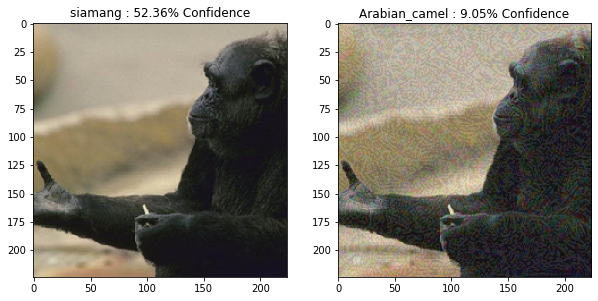

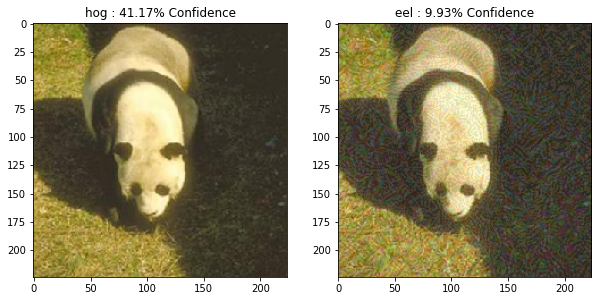

In [ ]:
i = np.random.choice(120, 1)[0]

x = img_data[i]
x = array_to_img(x)

y = perturbed_imgs[i]
y = array_to_img(y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 8])
ax1.imshow(x)
ax1.set_title('{} : {:.2f}% Confidence'.format(imagenet_labels[i][1], imagenet_labels[i][2]*100))
ax2.imshow(y)
ax2.set_title('{} : {:.2f}% Confidence'.format(pred_imagenet_labels[i][1], pred_imagenet_labels[i][2]*100))
fig.show

i = np.random.choice(120, 1)[0]

x = img_data[i]
x = array_to_img(x)

y = perturbed_imgs[i]
y = array_to_img(y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 8])
ax1.imshow(x)
ax1.set_title('{} : {:.2f}% Confidence'.format(imagenet_labels[i][1], imagenet_labels[i][2]*100))
ax2.imshow(y)
ax2.set_title('{} : {:.2f}% Confidence'.format(pred_imagenet_labels[i][1], pred_imagenet_labels[i][2]*100))
fig.show

## Defining some tools and loading necessary data

In [ ]:
# Importing libraries
from scipy.io import loadmat
import scipy.stats as st
from joblib import load
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

# Loading human data
!wget https://github.com/jcpeterson/percept2vec/blob/master/turkResults_CogSci2016.mat?raw=true
!mv turkResults_CogSci2016.mat\?raw\=true human_data.mat

# Human similarity matrix
human_data = loadmat('human_data.mat')
human_sim_matrix = human_data['simMatrix']
y = human_sim_matrix[np.triu_indices_from(human_sim_matrix)]

--2020-08-20 16:12:42--  https://github.com/jcpeterson/percept2vec/blob/master/turkResults_CogSci2016.mat?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jcpeterson/percept2vec/raw/master/turkResults_CogSci2016.mat [following]
--2020-08-20 16:12:42--  https://github.com/jcpeterson/percept2vec/raw/master/turkResults_CogSci2016.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jcpeterson/percept2vec/master/turkResults_CogSci2016.mat [following]
--2020-08-20 16:12:42--  https://raw.githubusercontent.com/jcpeterson/percept2vec/master/turkResults_CogSci2016.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.

In [ ]:
# Extracting features
def get_features(img_data, model, layer_idx = None, layer_label = None):
  assert(layer_idx is None or layer_label is None)

  if layer_idx is None and layer_label is None:
    output = model.layers[-2].output
  else:
    if layer_idx is not None:
      output = model.layers[layer_idx].output
    else:
      output = model.get_layer(layer_label).output

  extractor = tf.keras.models.Model(inputs = model.input, outputs = output)
  fmatrix = extractor.predict(img_data)
  fmatrix = fmatrix.reshape((120, -1))
  
  return fmatrix

# Generate similarity matrix
def generate_similarity(Fmatrix, weights = None):    
  if weights is None: 
    Smatrix = np.matmul(Fmatrix, Fmatrix.transpose())
  else:
    if weights.ndim == 1:
      weights = np.diag(weights)
    Smatrix = np.matmul(Fmatrix, np.matmul(weights, Fmatrix.transpose()))

  return Smatrix

# Compare two matrices
def compare(matrix1, matrix2, coeff = 'pearson'):
  assert(matrix1.shape == matrix2.shape)

  ind = np.triu_indices_from(matrix1)
  x = matrix1[ind]
  y = matrix2[ind]

  assert(coeff == 'pearson' or coeff == 'spearman')

  if coeff == 'pearson':
    (rho, pval) = st.pearsonr(x, y)
  else:
    (rho, pval) = st.spearmanr(x, y)

  return (rho, pval)

# Generate X matrix for regression
def generate_X_matrix(Fmatrix):
  N = Fmatrix.shape[0]
  ind = np.triu_indices(N)
  n = len(ind[0])

  X = np.zeros((n, Fmatrix.shape[1]))
  for i in np.arange(0, n):
    k = ind[0][i]
    l = ind[1][i]
    X[i] = Fmatrix[k]*Fmatrix[l]   

  return X

In [ ]:
# defining custom score function
def cor_square(y_true, y_pred):
  r, _ = st.pearsonr(y_true, y_pred)
  return r**2

score = make_scorer(cor_square)

# Searching for the best regularization parameter using GridSearch CV.
def get_alpha(fmatrix, target_matrix):
  X = generate_X_matrix(fmatrix)
  y = target_matrix[np.triu_indices_from(target_matrix)]
  reg = Ridge(fit_intercept=False, solver='sag')
  parameters = {'alpha': [1e3, 5*1e3, 1e4]}
  ridge_reg = GridSearchCV(reg, parameters, scoring='neg_mean_squared_error', cv=6, verbose=3, refit='neg_mean_squared_error')
  ridge_reg.fit(X, y)

  alpha = ridge_reg.best_params_
  best_reg = ridge_reg.best_estimator_

  return best_reg, alpha

# Running a ridge regression to adapt features to a target similarity matrix
def adapt_features(fmatrix, target_matrix, alpha = 1000):
  X = generate_X_matrix(fmatrix)
  y = target_matrix[np.triu_indices_from(target_matrix)]
  reg = Ridge(alpha = alpha, fit_intercept=False, solver='sag')
  reg_cv = cross_validate(reg, X, y, scoring=score, cv=6, return_estimator=True)

  s = reg_cv['test_score'].mean()
  return reg_cv, s

# calculate scores for a given data_set of images
def scores_calculator(fmatrix, human_matrix,  trans_weights = None, adapted_weights = None):
  raw_similarity = generate_similarity(fmatrix)
  (raw, pval) = compare(raw_similarity, human_matrix)

  trans_similarity = generate_similarity(fmatrix, trans_weights)
  (trans, pval) = compare(trans_similarity, human_matrix)

  if adapted_weights is None:
    _, score = adapt_features(fmatrix, human_matrix)

  return {'raw':raw**2, 'trans':trans**2, 'adapt':score}

## Adapting features from original images( for second last layer)

In [ ]:
original_features = get_features(img_data, pretrained_model)

In [ ]:
# Raw similarity
smatrix = generate_similarity(original_features)
r, _ = compare(smatrix, human_sim_matrix)
print(r**2)

0.23584776605126545


In [ ]:
# Adapt similarity
best_est, alpha = get_alpha(original_features, human_sim_matrix)  # Grid search for obtaining best regularization parameter
weights = best_est.coef_

In [ ]:
X_orig = generate_X_matrix(original_features)
score(best_est, X_orig, y)                     # This is the score after fitting on complete training set using best regularization parameter

0.7300579132024191

In [ ]:
reg_cv, s = adapt_features(original_features, human_sim_matrix, alpha = alpha['alpha'])
print(reg_cv['test_score'])                   # Score after each fold of cross-validation
print(s)                                      # Average score of 6-fold Cross-validation

[0.50577828 0.57505215 0.61557151 0.67010374 0.61238389 0.67384593]
0.6087892501508048


## Adapting features for adversarial images

### For epsilon = 3.5, Separate analysis

In [ ]:
feature_matrix = get_features(perturbed_imgs, pretrained_model)

In [ ]:
# Raw similarity matrix
sim_matrix = generate_similarity(feature_matrix)
(rho, pval) = compare(sim_matrix, human_sim_matrix)
print('Score for raw similarity matrix: ', rho**2)

Score for raw similarity matrix:  0.07538811953191682


In [ ]:
# Similarity matrix generated by using original weights
trans_sim_matrix = generate_similarity(feature_matrix, weights)
(rho, pval) = compare(trans_sim_matrix, human_sim_matrix)
print('Score for tansformed similarity matrix: ', rho**2)

Score for tansformed similarity matrix:  0.23231646018537683


In [ ]:
# Adapting features
reg_cv, s = adapt_features(feature_matrix, human_sim_matrix, alpha = alpha['alpha'])
print(reg_cv['test_score'])                   # Score after each fold of cross-validation
print('Score for adapted similarity matrix (mean cross-va;idation score for best estimator): ', s)     # Average score of 6-fold Cross-validation

KeyboardInterrupt: ignored

### Comparison for different values of epsilon

In [ ]:
epsilon = [0, 0.1,0.2,0.3,0.4,0.5]          # Added 0 for checking consistency
scores = []
accuracy = []

for eps in epsilon:
  print('Epsilon = ', eps)
  adverse_imgs = adversarial_imageset_generator(eps)
  accuracy.append(Accuracy(adverse_imgs, true_labels, pretrained_model))
  fmatrix = get_features(adverse_imgs, pretrained_model) 
  s = scores_calculator(fmatrix, human_sim_matrix, trans_weights = weights)
  scores.append([x for x in s.values()])

scores = np.asarray(scores)

In [ ]:
scores1 = []

for eps in epsilon:
  print('Epsilon = ', eps)
  adverse_imgs = adversarial_imageset_generator(eps)
  accuracy.append(Accuracy(adverse_imgs, true_labels, pretrained_model))
  fmatrix = get_features(adverse_imgs, pretrained_model) 
  reg = Ridge(alpha = alpha['alpha'], fit_intercept=False, solver='sag')
  X = generate_X_matrix(fmatrix)
  reg.fit(X, y)
  s = score(reg, X, y)
  scores1.append(s)

In [ ]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn-whitegrid')
plt.plot(epsilon,scores[:,0],label='RAW REPRESENTATIONS')
plt.plot(epsilon,scores[:,1],linestyle='dashed',label='ORIGINAL WEIGHTS')
plt.plot(epsilon,scores[:,2],linestyle='dotted',label='ADAPTED WEIGHTS (Average CV score)',linewidth=3)
plt.plot(epsilon,scores1,linestyle='dotted',label='ADAPTED WEIGHTS (On complete training data)',linewidth=3)
plt.title('R2 for raw,original and adapted', fontdict={'fontsize':20, 'color':'b'} )
plt.xlabel('epsilon', fontdict={'fontsize':20,'color':'g'} )
plt.ylabel('R-2',fontdict={'fontsize':20,'color':'g'})
plt.legend()

In [ ]:
scores1 = np.asarray(scores1)
np.hstack((scores, scores1.reshape(-1, 1)))

### For epislon = 20, Separate analysis

In [ ]:
adverse_imgs = adversarial_imageset_generator(20)
feature_matrix = get_features(adverse_imgs, pretrained_model)

In [ ]:
# Raw similarity matrix
smatrix = generate_similarity(feature_matrix)
(rho, pval) = compare(smatrix, human_sim_matrix)
print('Score for raw similarity matrix: ', rho**2)

In [ ]:
# Similarity matrix generated by using original weights
tmatrix = generate_similarity(feature_matrix, weights)
(rho, pval) = compare(tmatrix, human_sim_matrix)
print('Score for tansformed similarity matrix: ', rho**2)

In [ ]:
# Adapting features
reg_cv, s = adapt_features(feature_matrix, human_sim_matrix, alpha = alpha['alpha'])
print(reg_cv['test_score'])                   # Score after each fold of cross-validation
print('Score for adapted similarity matrix (mean cross-va;idation score for best estimator): ', s)     # Average score of 6-fold Cross-validation

In [ ]:
reg = Ridge(alpha = alpha['alpha'], fit_intercept=False, solver='sag')
X = generate_X_matrix(feature_matrix)
reg.fit(X, y)
s = score(reg, X, y)
print(s)

## Using original weights

In [ ]:
original_features = get_features(img_data, pretrained_model,layer_label='global_average_pooling2d')

In [ ]:
reg_cv, s = adapt_features(original_features, human_sim_matrix)

In [ ]:
reg_cv

{'estimator': (Ridge(alpha=1000, copy_X=True, fit_intercept=False, max_iter=None,
        normalize=False, random_state=None, solver='sag', tol=0.001),
  Ridge(alpha=1000, copy_X=True, fit_intercept=False, max_iter=None,
        normalize=False, random_state=None, solver='sag', tol=0.001),
  Ridge(alpha=1000, copy_X=True, fit_intercept=False, max_iter=None,
        normalize=False, random_state=None, solver='sag', tol=0.001),
  Ridge(alpha=1000, copy_X=True, fit_intercept=False, max_iter=None,
        normalize=False, random_state=None, solver='sag', tol=0.001),
  Ridge(alpha=1000, copy_X=True, fit_intercept=False, max_iter=None,
        normalize=False, random_state=None, solver='sag', tol=0.001),
  Ridge(alpha=1000, copy_X=True, fit_intercept=False, max_iter=None,
        normalize=False, random_state=None, solver='sag', tol=0.001)),
 'fit_time': array([0.92106628, 1.27646852, 0.9942112 , 1.13140416, 1.0592773 ,
        0.9854486 ]),
 'score_time': array([0.00236464, 0.00263596, 0.00

In [ ]:
epsilon = [0, 0.1,0.2,0.3,0.4,0.5] 

In [ ]:
r2 = []

## Original weights on adversial images(whole data)

In [ ]:
for eps in epsilon:
  adverse_imgs = adversarial_imageset_generator(eps)
  fmatrix = get_features(adverse_imgs, pretrained_model)
  X = generate_X_matrix(fmatrix)
  r = 0
  for reg in reg_cv['estimator']:
    r += score(reg, X, y)/6
  r2.append(r)

In [ ]:
r2

[0.7095193083752656,
 0.23404651794331252,
 0.09587277082761465,
 0.027641407591374373,
 0.022345312397032774,
 0.021303602876083565]

In [ ]:
r3 = []

## Original weights on adversial images(6 fold data)

In [ ]:
for eps in epsilon:
  adverse_imgs = adversarial_imageset_generator(eps)
  fmatrix = get_features(adverse_imgs, pretrained_model)
  X = generate_X_matrix(fmatrix)
  fold = KFold(n_splits=6).split(X)
  r = 0
  for reg in reg_cv['estimator']:
    ind = next(fold)[1]
    r += score(reg, X[ind], y[ind])/6
  r3.append(r)

In [ ]:
r3

[0.6087732914251219,
 0.21618757361309032,
 0.1033750835403688,
 0.03671571071166972,
 0.02615097271114163,
 0.022745780897551974]

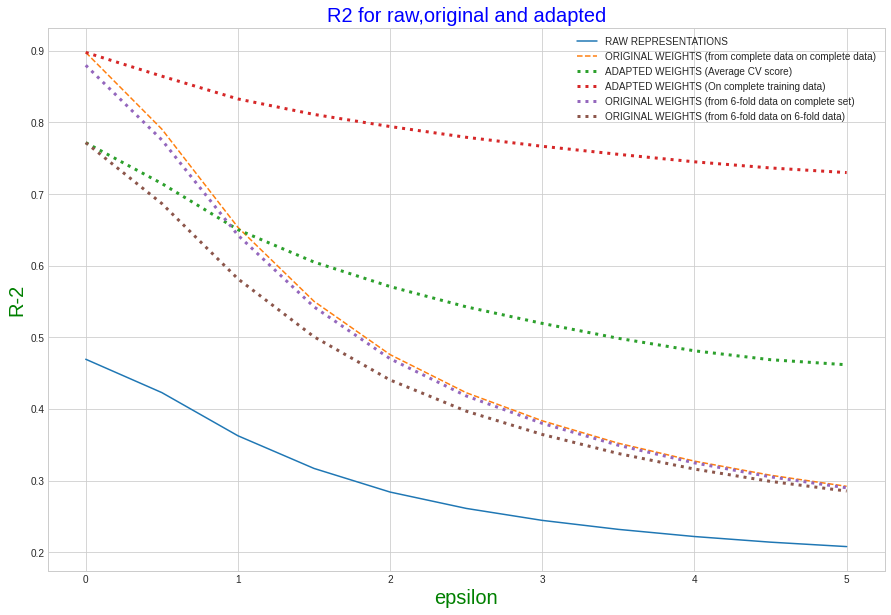

In [ ]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn-whitegrid')
plt.plot(epsilon,cc[:,0],label='RAW REPRESENTATIONS')
plt.plot(epsilon,cc[:,1],linestyle='dashed',label='ORIGINAL WEIGHTS (from complete data on complete data)')
plt.plot(epsilon,cc[:,2],linestyle='dotted',label='ADAPTED WEIGHTS (Average CV score)',linewidth=3)
plt.plot(epsilon,cc[:,3],linestyle='dotted',label='ADAPTED WEIGHTS (On complete training data)',linewidth=3)
plt.plot(epsilon,cc[:,4],linestyle='dotted',label='ORIGINAL WEIGHTS (from 6-fold data on complete set)',linewidth=3)
plt.plot(epsilon,cc[:,5],linestyle='dotted',label='ORIGINAL WEIGHTS (from 6-fold data on 6-fold data)',linewidth=3)
plt.title('R2 for raw,original and adapted', fontdict={'fontsize':20, 'color':'b'} )
plt.xlabel('epsilon', fontdict={'fontsize':20,'color':'g'} )
plt.ylabel('R-2',fontdict={'fontsize':20,'color':'g'})
plt.legend()

## Miscellaneous

In [ ]:
reg_x = Ridge(alpha = 10000, fit_intercept= False, solver='sag')

In [ ]:
X_orig = generate_X_matrix(original_features)

In [ ]:
reg_x.fit(X_orig, y)

Ridge(alpha=10000, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='sag', tol=0.001)

In [ ]:
score(reg_x, X_orig, y)

0.8978571169964105

In [ ]:
r4 = []

In [ ]:
for eps in epsilon:
  adverse_imgs = adversarial_imageset_generator(eps)
  fmatrix = get_features(adverse_imgs, pretrained_model)
  X = generate_X_matrix(fmatrix)
  folds = KFold(n_splits=6).split(X)
  r = 0
  for fold in folds:
    r += score(reg_x, X[fold[1]], y[fold[1]])/6
  r4.append(r)

In [ ]:
r4

[0.8957744178413255,
 0.7907595785554347,
 0.6561154529700356,
 0.5548414932424462,
 0.4812225688589816,
 0.42875999511648494,
 0.3900740046590684,
 0.3594835162170595,
 0.33516004617099154,
 0.31600803994242,
 0.3011278188720149]

In [ ]:
or_sc = np.asarray([[0.89785551,
0.7907113,
0.65359737,
0.55024631,
0.47578574,
0.42260368,
0.38335724,
0.35206458,
0.32705466,
0.30733552,
0.29187919],
[0.8798890594081301,
 0.7755827029715987,
 0.6426230829638565,
 0.5424862200719054,
 0.47001933925816264,
 0.4181186520987068,
 0.37978722578462376,
 0.3491997485067794,
 0.3246170674350969,
 0.3051185304150296,
 0.28978187696269675],
 [0.7718613767628697,
 0.6867831462261935,
 0.5816578237112418,
 0.5007384052527718,
 0.4403633782461849,
 0.3968846300274027,
 0.36429968253588974,
 0.3376668665814744,
 0.3159490580698691,
 0.2987307860305058,
 0.285317814166502],
 [0.8957744178413255,
 0.7907595785554347,
 0.6561154529700356,
 0.5548414932424462,
 0.4812225688589816,
 0.42875999511648494,
 0.3900740046590684,
 0.3594835162170595,
 0.33516004617099154,
 0.31600803994242,
 0.3011278188720149]])

In [ ]:
or_sc

array([[0.89785551, 0.7907113 , 0.65359737, 0.55024631, 0.47578574,
        0.42260368, 0.38335724, 0.35206458, 0.32705466, 0.30733552,
        0.29187919],
       [0.87988906, 0.7755827 , 0.64262308, 0.54248622, 0.47001934,
        0.41811865, 0.37978723, 0.34919975, 0.32461707, 0.30511853,
        0.28978188],
       [0.77186138, 0.68678315, 0.58165782, 0.50073841, 0.44036338,
        0.39688463, 0.36429968, 0.33766687, 0.31594906, 0.29873079,
        0.28531781],
       [0.89577442, 0.79075958, 0.65611545, 0.55484149, 0.48122257,
        0.42876   , 0.390074  , 0.35948352, 0.33516005, 0.31600804,
        0.30112782]])

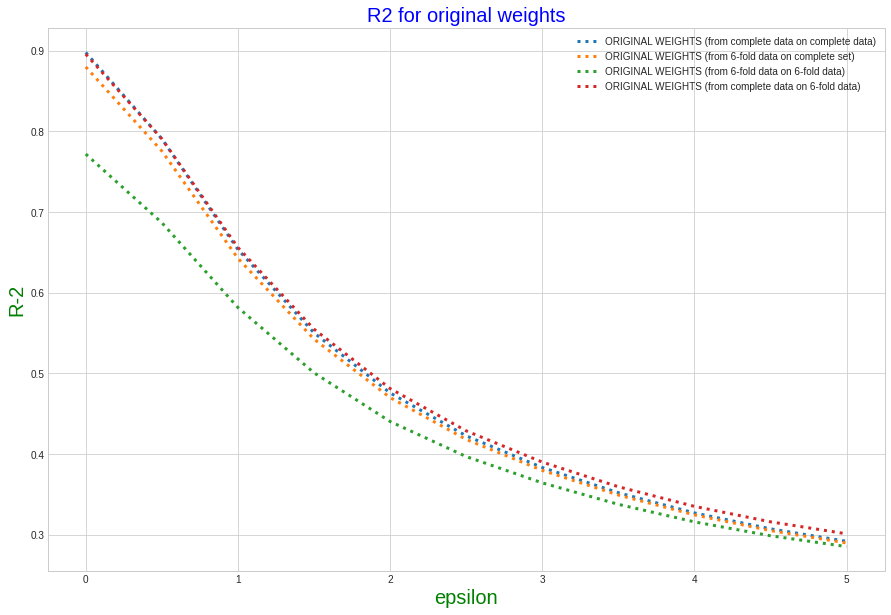

In [ ]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn-whitegrid')
plt.plot(epsilon,or_sc[0],linestyle='dotted',label='ORIGINAL WEIGHTS (from complete data on complete data)', linewidth=3)
plt.plot(epsilon,or_sc[1],linestyle='dotted',label='ORIGINAL WEIGHTS (from 6-fold data on complete set)',linewidth=3)
plt.plot(epsilon,or_sc[2],linestyle='dotted',label='ORIGINAL WEIGHTS (from 6-fold data on 6-fold data)',linewidth=3)
plt.plot(epsilon,or_sc[3],linestyle='dotted',label='ORIGINAL WEIGHTS (from complete data on 6-fold data)',linewidth=3)
plt.title('R2 for original weights', fontdict={'fontsize':20, 'color':'b'} )
plt.xlabel('epsilon', fontdict={'fontsize':20,'color':'g'} )
plt.ylabel('R-2',fontdict={'fontsize':20,'color':'g'})
plt.legend()

## Adversarial weights on original images

In [ ]:
epsilon = [0, 0.1,0.2,0.3,0.4,0.5]

In [ ]:
adv_sc = []

In [ ]:
X_orig = generate_X_matrix(original_features)

In [ ]:
for eps in epsilon:
  print('Epsilon = ', eps)
  adverse_imgs = adversarial_imageset_generator(eps)
  fmatrix = get_features(adverse_imgs, pretrained_model) 
  reg_cv, _ = adapt_features(fmatrix, human_sim_matrix)
  X = generate_X_matrix(fmatrix)
  r = [0, 0, 0]
  fold = KFold(n_splits = 6).split(X_orig)
  for est in reg_cv['estimator']:
    ind = next(fold)[1]
    r[0] += score(est, X_orig[ind], y[ind])/6
    r[1] += score(est, X_orig, y)/6
    r[2] += score(est, X[ind], y[ind])/6
  adv_sc.append(r)

Epsilon =  0
Epsilon =  0.5
Epsilon =  1
Epsilon =  1.5
Epsilon =  2
Epsilon =  2.5
Epsilon =  3
Epsilon =  3.5
Epsilon =  4
Epsilon =  4.5
Epsilon =  5


In [ ]:
adv_sc

[[0.7718495215667909, 0.8798611042532487, 0.7718495215667909],
 [0.7246165482825497, 0.8152092511277412, 0.71477046907178],
 [0.6660362889466207, 0.7386211502739902, 0.650386347247501],
 [0.6182882777662735, 0.6769291542983484, 0.6050803630251178],
 [0.5884768484652257, 0.6375719183147212, 0.570818781949266],
 [0.5675181532398357, 0.612097625866504, 0.5425752513002983],
 [0.5517745396535367, 0.5936214239401363, 0.5194081588661802],
 [0.5423084241106132, 0.5810248720525341, 0.4985901867530436],
 [0.5369509424457605, 0.5724071367299304, 0.48110565236798297],
 [0.5341230414941609, 0.5670158464829017, 0.4687271449574436],
 [0.5332780383299995, 0.5643795017830517, 0.46165363560027106]]

In [ ]:
adv_sc = np.asarray(adv_sc)

In [ ]:
r6 = []

In [ ]:
for eps in epsilon:
  print('Epsilon = ', eps)
  adverse_imgs = adversarial_imageset_generator(eps)
  fmatrix = get_features(adverse_imgs, pretrained_model) 
  X = generate_X_matrix(fmatrix)
  reg = Ridge(alpha = 10000, fit_intercept=False, solver = 'sag')
  reg.fit(X, y)
  r = [0, 0]
  r[0] = score(reg, X_orig, y)
  folds = KFold(n_splits = 6).split(X_orig)
  for fold in folds:
    ind = fold[1]
    r[1] += score(reg, X_orig[ind], y[ind])/6
  r6.append(r)

Epsilon =  0
Epsilon =  0.5
Epsilon =  1
Epsilon =  1.5
Epsilon =  2
Epsilon =  2.5
Epsilon =  3
Epsilon =  3.5
Epsilon =  4
Epsilon =  4.5
Epsilon =  5


In [ ]:
r6

[[0.8977280567248125, 0.5563855445980435],
 [0.8298677392094045, 0.5563855445980435],
 [0.7498396211248374, 0.5563855445980435],
 [0.6837784514345769, 0.5563855445980435],
 [0.6427272132259314, 0.5563855445980435],
 [0.6173247894598072, 0.5563855445980435],
 [0.5991634648906071, 0.5563855445980435],
 [0.5868961409135441, 0.5563855445980435],
 [0.5786259725393721, 0.5563855445980435],
 [0.5734398588678503, 0.5563855445980435],
 [0.5706903591031474, 0.5563855445980435],
 [0.8978515933824193, 0.8957689128305688],
 [0.8298631724097079, 0.8289173640313816],
 [0.749959993063592, 0.7495447682625733],
 [0.6838264420255377, 0.6833447742958055],
 [0.642721367513478, 0.641895473611734],
 [0.6172860875212579, 0.6160378478718224],
 [0.5991039938648819, 0.5978216795987048],
 [0.5869506757566012, 0.5860507565542673],
 [0.5787549300799114, 0.578322193307625],
 [0.5733883066491535, 0.5734202468374393],
 [0.5707806948897436, 0.5711077519070187]]

In [ ]:
r6 = r6[11:]

In [ ]:
adv_sc = np.delete(adv_sc, 2, 1)

In [ ]:
adv_sc = np.hstack((adv_sc, np.asarray(r6)))

In [ ]:
adv_sc

array([[0.77184952, 0.8798611 , 0.89785159, 0.89576891],
       [0.72461655, 0.81520925, 0.82986317, 0.82891736],
       [0.66603629, 0.73862115, 0.74995999, 0.74954477],
       [0.61828828, 0.67692915, 0.68382644, 0.68334477],
       [0.58847685, 0.63757192, 0.64272137, 0.64189547],
       [0.56751815, 0.61209763, 0.61728609, 0.61603785],
       [0.55177454, 0.59362142, 0.59910399, 0.59782168],
       [0.54230842, 0.58102487, 0.58695068, 0.58605076],
       [0.53695094, 0.57240714, 0.57875493, 0.57832219],
       [0.53412304, 0.56701585, 0.57338831, 0.57342025],
       [0.53327804, 0.5643795 , 0.57078069, 0.57110775]])

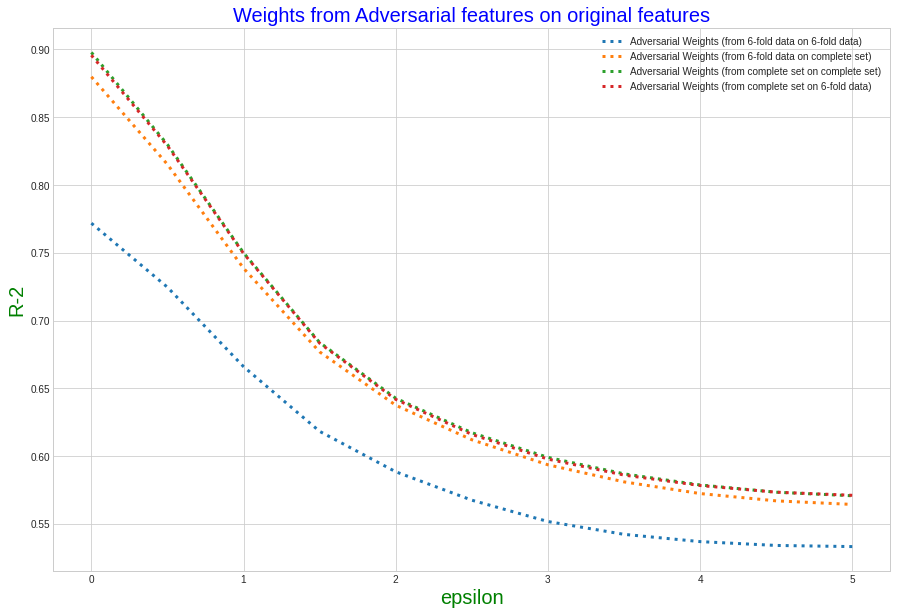

In [ ]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn-whitegrid')
plt.plot(epsilon,adv_sc[:,0],linestyle='dotted',label='Adversarial Weights (from 6-fold data on 6-fold data)', linewidth=3)
plt.plot(epsilon,adv_sc[:,1],linestyle='dotted',label='Adversarial Weights (from 6-fold data on complete set)',linewidth=3)
plt.plot(epsilon,adv_sc[:,2],linestyle='dotted',label='Adversarial Weights (from complete set on complete set)',linewidth=3)
plt.plot(epsilon,adv_sc[:,3],linestyle='dotted',label='Adversarial Weights (from complete set on 6-fold data)',linewidth=3)
plt.title('Weights from Adversarial features on original features', fontdict={'fontsize':20, 'color':'b'} )
plt.xlabel('epsilon', fontdict={'fontsize':20,'color':'g'} )
plt.ylabel('R-2',fontdict={'fontsize':20,'color':'g'})
plt.legend()

## Final graph

In [ ]:
values = [[0.4693471, 0.42276595, 0.36248566, 0.31685596, 0.28385923, 0.261037, 0.2442959, 0.23175409, 0.22175717, 0.21389094, 0.20771209],
 [0.77186138, 0.68678315, 0.58165782, 0.50073841, 0.44036338, 0.39688463, 0.36429968, 0.33766687, 0.31594906, 0.29873079, 0.28531781],
 [0.77184952, 0.72461655, 0.66603629, 0.61828828, 0.58847685, 0.56751815, 0.55177454, 0.54230842, 0.53695094, 0.53412304, 0.53327804],
 [0.77180786, 0.71473712, 0.65029182, 0.60509322, 0.57086486, 0.54256264, 0.51937611, 0.49859032, 0.48112806, 0.46868859, 0.46163302]]

In [ ]:
epsilon = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5] 

In [ ]:
values = np.asarray(values)

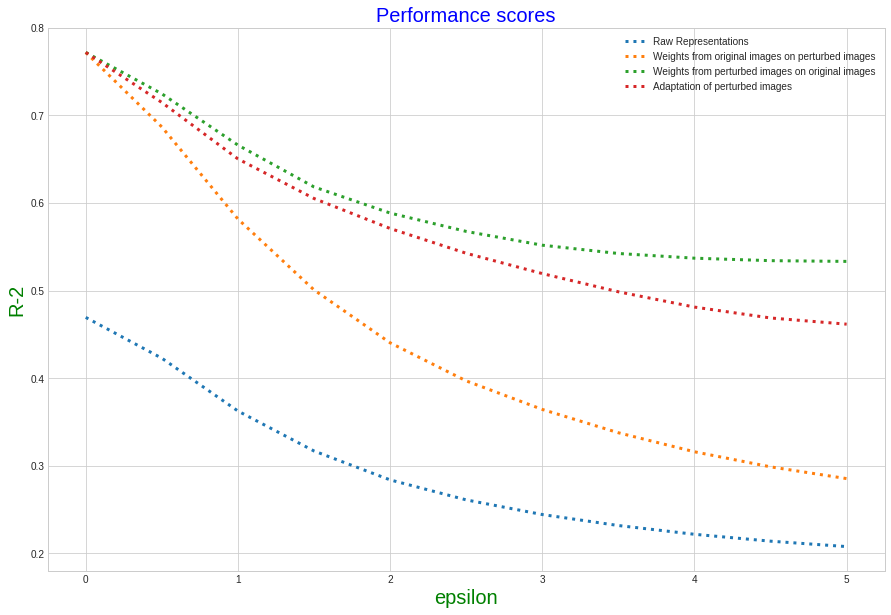

In [ ]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn-whitegrid')
plt.plot(epsilon,values[0],linestyle='dotted',label='Raw Representations',linewidth=3)
plt.plot(epsilon,values[1],linestyle='dotted',label='Weights from original images on perturbed images',linewidth=3)
plt.plot(epsilon,values[2],linestyle='dotted',label='Weights from perturbed images on original images',linewidth=3)
plt.plot(epsilon,values[3],linestyle='dotted',label='Adaptation of perturbed images',linewidth=3)
plt.title('Performance scores', fontdict={'fontsize':20, 'color':'b'})
plt.xlabel('epsilon', fontdict={'fontsize':20,'color':'g'} )
plt.ylabel('R-2',fontdict={'fontsize':20,'color':'g'})
plt.legend()